# TESTING

In [1]:
from utils import *
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.covariance import empirical_covariance

import matplotlib.pyplot as plt

N = 5

data = prepare_mnist_data()
trainX = data['trainX']
trainY = data['trainY']

unique, counts = np.unique(trainY, return_counts=True)
for u,c in zip(unique,counts):
    print(f"class {u}: instances {c}")

def Covariance(X,y):
    N_features = X.shape[1]
    cov_vec = np.zeros(N_features)
    for i in range(X.shape[1]):
        x_i = X[:,i]
        xbar, ybar = x_i.mean(), y.mean()
        cov_vec[i] = np.sum((x_i-xbar)*(y-ybar))/(len(x_i)-1)
    return cov_vec

class 0.0: instances 327
class 3.0: instances 356
class 4.0: instances 317


**CLUSTERING**

(784,)
0.30447099999998545
0.30447100000000005
9497.502784000053


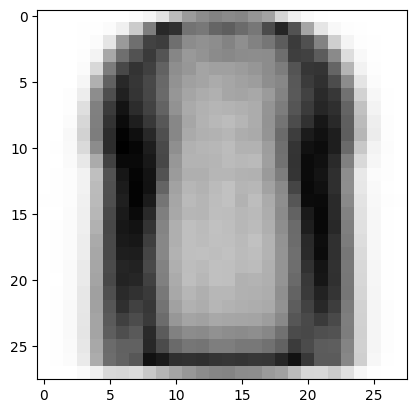

In [2]:
foo = np.var(trainX, axis=0)
print(foo.shape)
print(foo[0])
print(np.var(trainX[:,0]))
print(max(foo))

plt.imshow(np.reshape(foo, (28,28)), cmap=plt.get_cmap('Greys'), interpolation='nearest')
plt.show()

**CLASSIFICATION**

In [59]:
# Get dataset unique labels and the sample indices corresponding to those labels
from scipy.spatial.distance import cdist
from gekko import GEKKO

unique_labels = np.unique(trainY)
indices_per_label = []
for i, label in enumerate(unique_labels):
    indices = np.where(trainY == label)
    indices_per_label.append(indices)

# Assume no access to itertools, just use the known possible pairs given the fashion mnist dataset
label_pairs = ((0,1), (0,2), (1,2))

pairwise_covariances = []

# Iterate across all potential label pairs
for (lbl_idx_a, lbl_idx_b) in label_pairs:
    lbl_a = unique_labels[lbl_idx_a]
    lbl_b = unique_labels[lbl_idx_b]

    # Combine sample indices from both classes
    indices = np.append(indices_per_label[lbl_idx_a], indices_per_label[lbl_idx_b])

    # Get X and Y samples from the indices
    X_prime = np.take(trainX, indices, axis=0)
    Y_prime = np.take(trainY, indices)
    
    # X_prime = trainX.copy()
    # Y_prime = trainY.copy()

    # print(X_prime.shape)
    # print(Y_prime.shape)

    # relabel original class labels to -1, +1
    for i in range(len(Y_prime)):
        if Y_prime[i] == lbl_a:
            Y_prime[i] = 1
        elif Y_prime[i] == lbl_b:
        # else:
            Y_prime[i] = -1
    
    # compute covariance for the pair of labels
    pair_covariance = Covariance(X_prime, Y_prime)
    pairwise_covariances.append(np.absolute(pair_covariance))

    # constraints = LinearConstraint
    # selection = cvxpy.Variable(trainX.shape[1])

    # variable = cvxpy.

feature_counts = [5, 20, 80, 320, 784]
# feature_counts = [20]

selected_features = {}

for feature_count in feature_counts:
    mdl = GEKKO(remote=False)

    # Define max features
    K = mdl.Const(feature_count)

    # Define covariance vector constants
    z_0_1 = [mdl.Const(value=val) for val in pairwise_covariances[0]]
    z_0_2 = [mdl.Const(value=val) for val in pairwise_covariances[1]]
    z_1_2 = [mdl.Const(value=val) for val in pairwise_covariances[2]]

    # Define t_min auxiliary variable
    t_min = mdl.Var(value=0, lb=0)

    # Define pixel selection vector, with its integrality and 0/1 constraints
    # s = [mdl.Var(value=0, lb=0, ub=1, integer=True) for i in range(trainX.shape[1])]
    s = [mdl.Var(value=0, lb=0, ub=1) for i in range(trainX.shape[1])]


    # Add regularization variables to incentivize distance bewteen seleted points
    # Want to try to minimize variance across each dimension - spread selected pixels equally across columns and rows
    
    image_side_length = int(trainX.shape[1]**.5)
    # Column sum
    col_sums = [mdl.Intermediate(mdl.sum([s[i+image_side_length*j] for j in range(image_side_length)])) for i in range(image_side_length)]
    # Row sum
    row_sums = [mdl.Intermediate(mdl.sum([s[image_side_length*i+j] for j in range(image_side_length)])) for i in range(image_side_length)]

    # Row and column averages
    col_avg = mdl.Intermediate(sum(col_sums) / image_side_length)
    row_avg = mdl.Intermediate(sum(row_sums) / image_side_length)

    # Absolute col/row sum deviations from average
    col_abs_deviation = [mdl.abs2(csum-col_avg) for csum in col_sums]
    row_abs_deviation = [mdl.abs2(rsum-row_avg) for rsum in row_sums]

    # Compute variances for rows and columns
    col_var = mdl.Intermediate(mdl.sum([dev for dev in col_abs_deviation]) / (image_side_length))
    row_var = mdl.Intermediate(mdl.sum([dev for dev in row_abs_deviation]) / (image_side_length))

    lambda1 = 1E2
    lambda2 = 1E2


    # print(len(s))
    # Define constraints
    ## Max number of pixels constraint
    mdl.Equation(np.sum(s) <= K)

    ## Set t_min to the min sum absolute covariance across all class pairs
    # mdl.Equation(t_min <= np.dot(s, z_0_1))
    # mdl.Equation(t_min <= np.dot(s, z_0_2))
    # mdl.Equation(t_min <= np.dot(s, z_1_2))
    ### Reformulate dot products as element-wise multiply and sum to avoid errors in GEKKO
    mdl.Equation(t_min <= mdl.sum([s_i*z_0_1_i for (s_i, z_0_1_i) in zip(s,z_0_1)]))
    mdl.Equation(t_min <= mdl.sum([s_i*z_0_2_i for (s_i, z_0_2_i) in zip(s,z_0_2)]))
    mdl.Equation(t_min <= mdl.sum([s_i*z_1_2_i for (s_i, z_1_2_i) in zip(s,z_1_2)]))

    
    # Set objective function to maximize t_min - regularization terms
    mdl.Maximize(t_min - lambda1*col_var - lambda2*row_var)

    # mdl.Obj(t_min + ())

    # mdl.options.MAX_ITER = 400
    mdl.options.SOLVER = 1    
    mdl.options.IMODE = 3

    mdl.solver_options = [  'minlp_gap_tol 1.0e-1',\
                            'minlp_maximum_iterations 1000',\
                            'minlp_max_iter_with_int_sol 400']

    mdl.solve(disp=True)

    print(f"t value: {t_min.value}")
    # print(f"col_avg value: {col_avg.value}")
    # print(f"row_avg value: {row_avg.value}")
    # print(f"col_abs_deviation value: {[cad.value for cad in col_abs_deviation]}")
    # print(f"row_abs_deviation value: {[rad.value for rad in row_abs_deviation]}")
    print(f"col_var value: {col_var.value}")
    print(f"row_var value: {row_var.value}")
    # print(f"reg1 value: {reg1.value}")
    # print(f"reg2 value: {reg2.value}")

    selected_features[feature_count] = np.array([s_i.value for s_i in s])

 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  117
   Constants    :  2353
   Variables    :  3314
   Intermediates:  60
   Connections  :  4149
   Equations    :  2473
   Residuals    :  2413
 
 Number of state variables:    3426
 Number of total equations: -  2585
 Number of slack variables: -  4
 ---------------------------------------
 Degrees of freedom       :    837
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0 -3.86743E-01  5.00000E+00
    1 -1.00253E+02  4.67481E-07
    2 -2.19195E+02  1.00000E-10
    3 -2.21949E+02  2.00004E-10
    4 -2.22208E+02  3.00000E-10
    5 -2.23588E+02  1.00000E-10
    6 -2.23923E+02  2.00004

Original num of nonzero features: 54


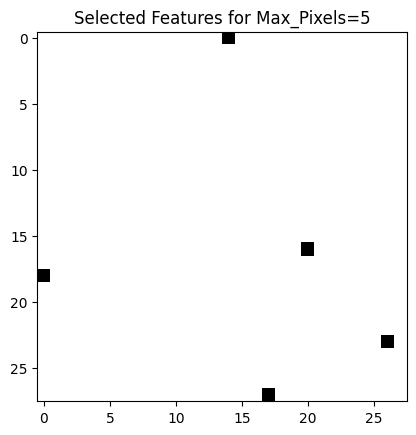

[ 14 468 504 670 773]
Selected Features: 5
Original num of nonzero features: 44


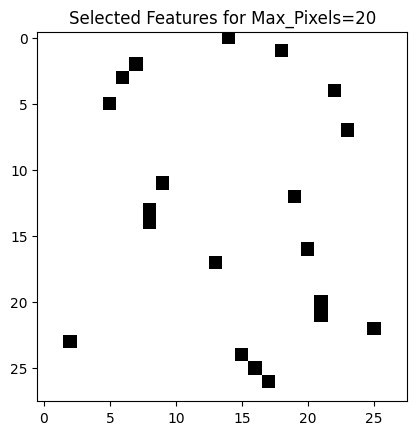

[ 14  46  63  90 134 145 219 317 355 372 400 468 489 581 609 641 646 687
 716 745]
Selected Features: 20
Original num of nonzero features: 83


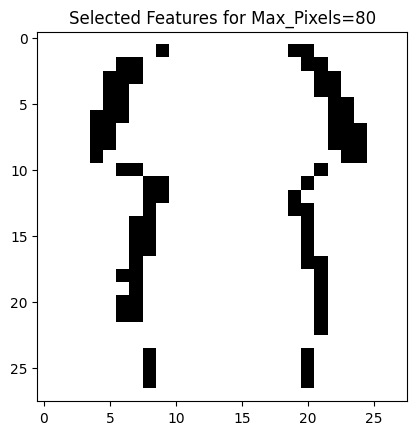

[ 37  47  48  62  63  76  77  89  90  91 105 106 117 118 133 134 145 146
 162 163 172 173 174 190 191 200 201 218 219 220 228 229 246 247 248 256
 275 276 286 287 301 316 317 328 344 345 355 372 383 384 399 400 412 427
 428 440 455 456 468 483 496 497 510 511 525 539 553 566 567 581 594 595
 609 637 680 692 708 720 736 748]
Selected Features: 80
Original num of nonzero features: 329


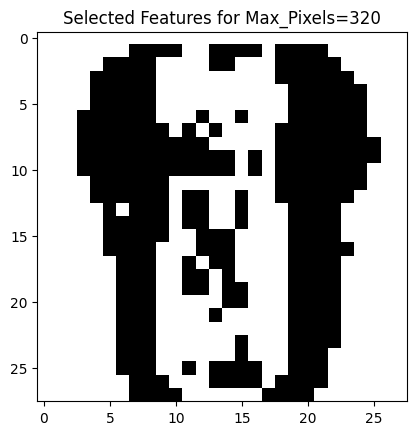

[ 35  36  37  38  41  42  43  44  46  47  48  49  61  62  63  64  69  70
  74  75  76  77  78  88  89  90  91  92 102 103 104 105 106 107 116 117
 118 119 120 131 132 133 134 135 136 144 145 146 147 148 159 160 161 162
 163 164 171 172 173 174 175 176 180 183 187 188 189 190 191 192 199 200
 201 202 203 204 205 207 209 214 215 216 217 218 219 220 227 228 229 230
 231 232 233 234 235 236 242 243 244 245 246 247 248 249 255 256 257 258
 259 260 261 262 263 264 265 266 268 270 271 272 273 274 275 276 277 283
 284 285 286 287 288 289 290 291 292 293 294 296 298 299 300 301 302 303
 304 312 313 314 315 316 317 326 327 328 329 330 331 332 340 341 342 343
 344 345 347 348 351 354 355 356 357 358 359 369 371 372 373 375 376 379
 383 384 385 386 397 398 399 400 401 403 404 407 411 412 413 414 425 426
 427 428 429 432 433 434 439 440 441 442 453 454 455 456 460 461 462 467
 468 469 470 471 482 483 484 487 489 490 495 496 497 498 510 511 512 515
 516 518 523 524 525 526 538 539 540 543 544 546 54

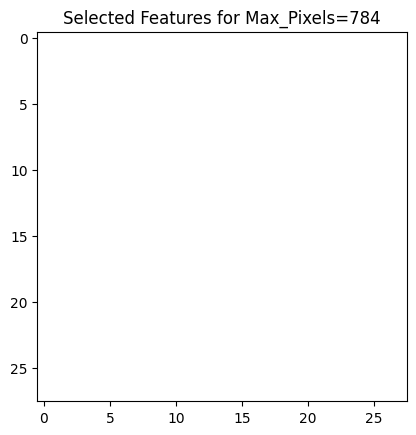

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [58]:
for feature_count in feature_counts:
    features = selected_features[feature_count].flatten()

    print(f"Original num of nonzero features: {len(np.nonzero(features)[0])}")

    # Take the max features and display
    ind = np.argpartition(features, -1*feature_count)[-1*feature_count:]
    features = np.zeros(784)
    features[ind]=1


    plt.imshow(np.reshape(features, (28,28)), cmap=plt.get_cmap('Greys'), interpolation='nearest')
    plt.title(f"Selected Features for Max_Pixels={feature_count}")
    plt.show()

    feature_indices = np.nonzero(features)[0]
    print(feature_indices)
    print(f"Selected Features: {len(feature_indices)}")
    

**CLASSIFICATION FEATURES BACKUP**

In [51]:
classification_features_K5 = np.array([173, 190, 201, 219, 553])

classification_features_K20 = np.array([ 90, 134, 145, 146, 162, 173, 190, 191, 201, 218, 219, 229, 247, 372, 427, 455, 497, 553,
                                566, 581])

classification_features_K80 = np.array([ 62,  63,  64,  76,  77,  89,  90,  91,  104, 105, 106, 117, 118, 133, 134, 135, 144, 145,
                                146, 162, 163, 172, 173, 174, 190, 191, 200, 201, 202, 218, 219, 228, 229, 230, 246, 247,
                                248, 256, 257, 258, 259, 273, 274, 275, 276, 286, 287, 288, 301, 314, 316, 328, 344, 372,
                                384, 399, 400, 412, 426, 427, 440, 455, 468, 469, 482, 483, 497, 510, 511, 525, 538, 553,
                                566, 581, 594, 609, 708, 736, 747, 748])

classification_features_K320 = np.array([    34,  35,  36,  37,  38,  41,  42,  43,  44,  46,  47,  48,  49,  61,  62,  63,  64,  65,
                                    70,  74,  75,  76,  77,  78,  88,  89,  90,  91,  92,  93,  102, 103, 104, 105, 106, 107,
                                    116, 117, 118, 119, 120, 121, 131, 132, 133, 134, 135, 144, 145, 146, 147, 148, 149, 152,
                                    159, 160, 161, 162, 163, 164, 171, 172, 173, 174, 175, 176, 177, 180, 182, 183, 186, 187,
                                    188, 189, 190, 191, 192, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 214, 215,
                                    216, 217, 218, 219, 220, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 242, 243,
                                    244, 245, 246, 247, 248, 249, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
                                    268, 270, 271, 272, 273, 274, 275, 276, 277, 283, 284, 285, 286, 287, 288, 289, 290, 291,
                                    292, 293, 294, 296, 298, 299, 300, 301, 302, 303, 304, 311, 312, 313, 314, 315, 316, 317,
                                    319, 326, 327, 328, 329, 330, 331, 332, 340, 341, 342, 343, 344, 345, 347, 348, 350, 351,
                                    354, 355, 356, 357, 358, 359, 369, 370, 371, 372, 373, 375, 376, 379, 383, 384, 385, 386,
                                    387, 397, 398, 399, 400, 401, 404, 411, 412, 413, 414, 425, 426, 427, 428, 429, 434, 439,
                                    440, 441, 442, 453, 454, 455, 456, 457, 460, 462, 467, 468, 469, 470, 481, 482, 483, 484,
                                    485, 490, 495, 496, 497, 498, 510, 511, 512, 513, 516, 523, 524, 525, 526, 538, 539, 540,
                                    541, 546, 551, 552, 553, 554, 566, 567, 568, 569, 579, 580, 581, 582, 594, 595, 596, 597,
                                    607, 608, 609, 610, 622, 623, 624, 625, 635, 636, 637, 638, 650, 651, 652, 653, 663, 664,
                                    665, 666, 678, 679, 680, 681, 691, 692, 693, 694, 706, 707, 708, 709, 719, 720, 721, 734,
                                    735, 736, 737, 742, 747, 748, 749, 763, 764, 765, 766, 774, 775, 776])

classification_features_K784 = np.array(range(0,784))

selected_features = {}
selected_features[5] = np.zeros(784)
selected_features[20] = np.zeros(784)
selected_features[80] = np.zeros(784)
selected_features[320] = np.zeros(784)
selected_features[784] = np.zeros(784)

selected_features[5][classification_features_K5] = 1
selected_features[20][classification_features_K20] = 1
selected_features[80][classification_features_K80] = 1
selected_features[320][classification_features_K320] = 1
selected_features[784][classification_features_K784] = 1

**CLUSTERING**

In [4]:
# Get dataset unique labels and the sample indices corresponding to those labels
from scipy.spatial.distance import cdist
from gekko import GEKKO

feature_counts = [5, 20, 80, 320, 784]
# feature_counts = [20]
selected_features = {}

for feature_count in feature_counts:
        print(f"running feature count: {feature_count}")
        # Compute pixel variances
        variance = np.var(trainX, axis=0)

        ## Formulate and run the Integer Linear Program
        mdl = GEKKO(remote=False)

        # Define max number of features
        K = mdl.Const(feature_count)

        # Define covariance vector constants
        z = [mdl.Const(value=val) for val in variance]

        # Define t_min auxiliary variable
        t = mdl.Var(value=0, lb=0)

        # Define pixel selection vector, with its integrality and 0/1 constraints
        # s = [mdl.Var(value=0, lb=0, ub=1, integer=True) for i in range(trainX.shape[1])]
        s = [mdl.Var(value=0, lb=0, ub=1) for i in range(trainX.shape[1])]


        # Add regularization variables to incentivize distance bewteen seleted points
        # Want to try to minimize variance across each dimension - spread selected pixels equally across columns and rows
        
        image_side_length = int(trainX.shape[1]**.5)
        # Column sum
        col_sums = [mdl.Intermediate(mdl.sum([s[i+image_side_length*j] for j in range(image_side_length)])) for i in range(image_side_length)]
        # Row sum
        row_sums = [mdl.Intermediate(mdl.sum([s[image_side_length*i+j] for j in range(image_side_length)])) for i in range(image_side_length)]

        # Row and column averages
        col_avg = mdl.Intermediate(sum(col_sums) / image_side_length)
        row_avg = mdl.Intermediate(sum(row_sums) / image_side_length)

        # Absolute col/row sum deviations from average
        col_abs_deviation = [mdl.abs2(csum-col_avg) for csum in col_sums]
        row_abs_deviation = [mdl.abs2(rsum-row_avg) for rsum in row_sums]

        # Compute variances for rows and columns
        col_var = mdl.Intermediate(mdl.sum([dev for dev in col_abs_deviation]) / (image_side_length))
        row_var = mdl.Intermediate(mdl.sum([dev for dev in row_abs_deviation]) / (image_side_length))

        lambda1 = 1E5
        lambda2 = 1E5


        # Define constraints
        ## Max number of pixels constraint
        mdl.Equation(np.sum(s) <= K)
        ## Set t to the sum variance across all selected pixels
        mdl.Equation(t <= mdl.sum([s_i*z_i for (s_i, z_i) in zip(s,z)]))
        

        # Set objective function to maximize t
        mdl.Maximize(t - lambda1*col_var - lambda2*row_var)
        mdl.options.MAX_ITER = 10000
        mdl.options.SOLVER = 1    
        mdl.options.IMODE = 3
        # mdl.solve(disp=True)
        mdl.solve()

        # Get the 1/0 mask of selected features from the final values of s
        feature_mask = np.array([s_i.value for s_i in s])
        
        print(f"t value: {t.value}")
        # print(f"col_avg value: {col_avg.value}")
        # print(f"row_avg value: {row_avg.value}")
        # print(f"col_abs_deviation value: {[cad.value for cad in col_abs_deviation]}")
        # print(f"row_abs_deviation value: {[rad.value for rad in row_abs_deviation]}")
        print(f"col_var value: {col_var.value}")
        print(f"row_var value: {row_var.value}")
        # print(f"reg1 value: {reg1.value}")
        # print(f"reg2 value: {reg2.value}")

        print([cs.value for cs in col_sums])

        selected_features[feature_count] = feature_mask

        # Get feature indices of the selected features from the mask
        selected_feature_indices = np.nonzero(feature_mask)[0]



running feature count: 5
 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  115
   Constants    :  785
   Variables    :  1742
   Intermediates:  60
   Connections  :  2579
   Equations    :  903
   Residuals    :  843
 
 Number of state variables:    1854
 Number of total equations: -  1013
 Number of slack variables: -  2
 ---------------------------------------
 Degrees of freedom       :    839
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0 -5.01416E-01  5.00000E+00
    1 -3.82804E+04  1.42021E-06
    2 -3.84785E+04  6.69404E-06
    3 -3.85310E+04  2.99998E-10
    4 -3.85324E+04  1.99999E-10
    5 -3.85324E+04  3.55271E-15
    6

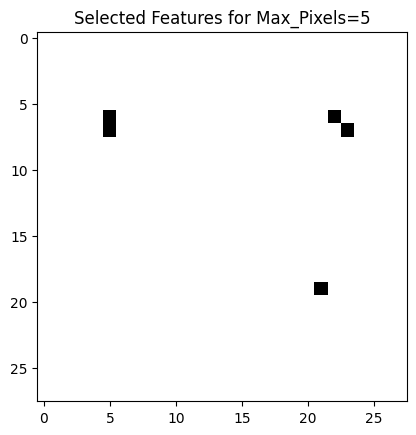

[173 190 201 219 553]
Selected Features: 5


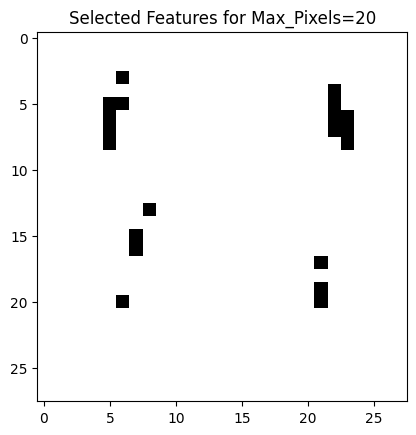

[ 90 134 145 146 162 173 190 191 201 218 219 229 247 372 427 455 497 553
 566 581]
Selected Features: 20


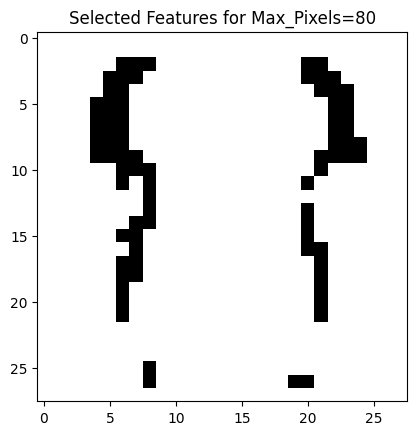

[ 62  63  64  76  77  89  90  91 104 105 106 117 118 133 134 135 144 145
 146 162 163 172 173 174 190 191 200 201 202 218 219 228 229 230 246 247
 248 256 257 258 259 273 274 275 276 286 287 288 301 314 316 328 344 372
 384 399 400 412 426 427 440 455 468 469 482 483 497 510 511 525 538 553
 566 581 594 609 708 736 747 748]
Selected Features: 80


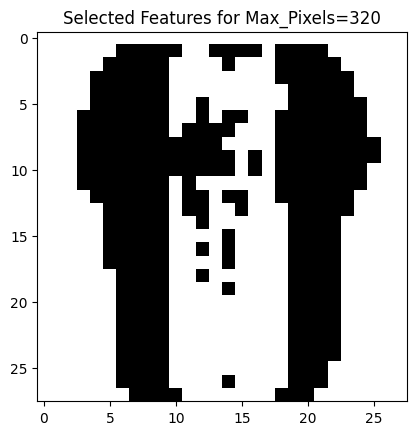

[ 34  35  36  37  38  41  42  43  44  46  47  48  49  61  62  63  64  65
  70  74  75  76  77  78  88  89  90  91  92  93 102 103 104 105 106 107
 116 117 118 119 120 121 131 132 133 134 135 144 145 146 147 148 149 152
 159 160 161 162 163 164 171 172 173 174 175 176 177 180 182 183 186 187
 188 189 190 191 192 199 200 201 202 203 204 205 207 208 209 210 214 215
 216 217 218 219 220 227 228 229 230 231 232 233 234 235 236 237 242 243
 244 245 246 247 248 249 255 256 257 258 259 260 261 262 263 264 265 266
 268 270 271 272 273 274 275 276 277 283 284 285 286 287 288 289 290 291
 292 293 294 296 298 299 300 301 302 303 304 311 312 313 314 315 316 317
 319 326 327 328 329 330 331 332 340 341 342 343 344 345 347 348 350 351
 354 355 356 357 358 359 369 370 371 372 373 375 376 379 383 384 385 386
 387 397 398 399 400 401 404 411 412 413 414 425 426 427 428 429 434 439
 440 441 442 453 454 455 456 457 460 462 467 468 469 470 481 482 483 484
 485 490 495 496 497 498 510 511 512 513 516 523 52

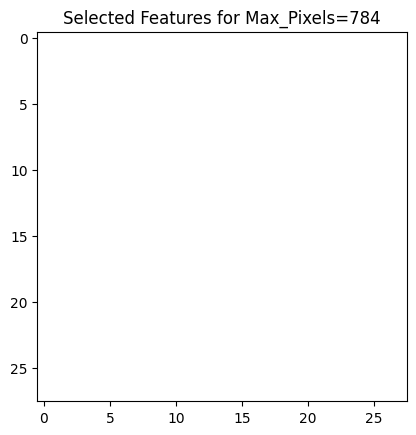

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [39]:
for feature_count in feature_counts:
    features = selected_features[feature_count].flatten()

    # Take the max features and display
    ind = np.argpartition(features, -1*feature_count)[-1*feature_count:]
    features = np.zeros(784)
    features[ind]=1

    plt.imshow(np.reshape(features, (28,28)), cmap=plt.get_cmap('Greys'), interpolation='nearest')
    plt.title(f"Selected Features for Max_Pixels={feature_count}")
    plt.show()
    

    feature_indices = np.nonzero(features)[0]
    print(feature_indices)
    print(f"Selected Features: {len(feature_indices)}")

**CLUSTERING FEATURES BACKUP**

In [37]:
cluster_features_K5 = [174, 230, 286, 553, 708]

cluster_features_K20 = [202, 230, 258, 286, 287, 314, 315, 343, 371, 384, 399, 412, 413, 427, 441, 469, 497, 553,
                581, 736,]

cluster_features_K80 = [ 37,   46, 146, 174, 189, 202, 203, 217, 230, 231, 245, 246, 257, 258, 259, 260, 272, 273,
                 274, 285, 286, 287, 288, 300, 301, 302, 314, 315, 316, 328, 329, 330, 342, 343, 344, 356,
                 357, 370, 371, 372, 384, 385, 398, 399, 400, 412, 413, 426, 427, 428, 440, 441, 454, 455,
                 468, 469, 470, 482, 483, 496, 497, 510, 511, 524, 525, 538, 539, 553, 566, 567, 581, 594,
                 609, 637, 680, 708, 736, 737, 746, 747,]

cluster_features_K320 = [ 12,  13,  14,  15,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  63,  64,
                  65,  66,  67,  69,  70,  72,  73,  74,  75,  76,  77,  90,  91,  92,  93,  94,  97,  98,
                  99, 100, 101, 102, 103, 104, 105, 106, 117, 118, 119, 120, 121, 129, 130, 131, 132, 133,
                 134, 145, 146, 147, 148, 149, 158, 159, 160, 161, 162, 163, 172, 173, 174, 175, 176, 177,
                 186, 187, 188, 189, 190, 191, 200, 201, 202, 203, 204, 205, 214, 215, 216, 217, 218, 219,
                 228, 229, 230, 231, 232, 233, 234, 242, 243, 244, 245, 246, 247, 256, 257, 258, 259, 260,
                 261, 262, 270, 271, 272, 273, 274, 275, 284, 285, 286, 287, 288, 289, 298, 299, 300, 301,
                 302, 303, 313, 314, 315, 316, 317, 326, 327, 328, 329, 330, 331, 341, 342, 343, 344, 345,
                 354, 355, 356, 357, 358, 369, 370, 371, 372, 373, 382, 383, 384, 385, 386, 397, 398, 399,
                 400, 401, 411, 412, 413, 414, 415, 425, 426, 427, 428, 429, 438, 439, 440, 441, 442, 443,
                 453, 454, 455, 456, 457, 467, 468, 469, 470, 471, 481, 482, 483, 484, 485, 495, 496, 497,
                 498, 499, 509, 510, 511, 512, 513, 523, 524, 525, 526, 527, 537, 538, 539, 540, 541, 551,
                 552, 553, 554, 555, 565, 566, 567, 568, 569, 579, 580, 581, 582, 583, 593, 594, 595, 596,
                 597, 607, 608, 609, 610, 611, 621, 622, 623, 624, 625, 635, 636, 637, 638, 639, 649, 650,
                 651, 652, 653, 662, 663, 664, 665, 666, 667, 677, 678, 679, 680, 681, 682, 683, 684, 687,
                 689, 690, 691, 692, 693, 694, 695, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715,
                 716, 717, 718, 719, 720, 721, 722, 723, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742,
                 743, 744, 745, 746, 747, 748, 749, 750, 751, 768, 769, 770, 771, 772,]

cluster_features_K784 = range(0,784)

In [26]:
foo = selected_features[5].flatten()

print(foo.shape)
print(np.nonzero(foo))
bar = np.argpartition(foo, -5)[-5:]
print(bar)
print(foo[bar])

(784,)
(array([ 38,  46,  65,  75, 103, 146, 174, 201, 202, 230, 258, 286, 328,
       343, 371, 399, 441, 469, 497, 525, 553, 581, 610, 637, 680, 708,
       738, 740], dtype=int64),)
[553 174 708 230 286]
[0.17857143 0.17857143 0.17857143 0.17857143 0.89285714]
